# k-scheduling tests

In [1]:
import matplotlib.pyplot as plt
import numpy as np

from random import sample, seed
from tqdm import tqdm

from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, Aer, transpile, assemble
from qiskit.algorithms import amplitude_estimators, EstimationProblem
from qiskit.algorithms import IterativeAmplitudeEstimation as BaseIterativeAmplitudeEstimation

from algorithms import IterativeAmplitudeEstimation, MaximumLikelihoodAmplitudeEstimation, FasterAmplitudeEstimation
from operators import *

In [2]:
n = 4
N = 2**n
k = N//2
marked = sample(range(N), k)

In [3]:
# Define the estimation problem and oracle function
def good_state(state):
    bin_marked = [(n-len(bin(s))+2)*'0'+bin(s)[2:] for s in marked]
    return (state in bin_marked)

problem = EstimationProblem(
    state_preparation=A(n),  # A operator
    grover_operator=Q(n, marked),  # Q operator
    objective_qubits=range(n),
    is_good_state=good_state  # the "good" state Psi1 is identified as measuring |1> in qubit 0
)

In [4]:
# use local simulator
aer_sim = Aer.get_backend('aer_simulator')
shots = 100

## IQAE: attempt exponential decay in the number of shots per iteration to account for deeper circuits.

In [5]:
# TODO: package this in a function to make it nicer / generalize

# n_trials = 100
# max_depth_log2 = 5
# queries = np.zeros((max_depth_log2-1, n_trials))
# errs = np.zeros((max_depth_log2-1, n_trials))

# for i in range(2,max_depth_log2+1):
#     for j in range(n_trials):
#         mlae = MLAE(range(i), quantum_instance=aer_sim)
#         result = mlae.estimate(problem)
#         queries[i-2,j] = result.num_oracle_queries
#         errs[i-2,j] = abs(k/N - result.estimation)

In [6]:
# parameters for IQAE
alpha = 0.05
confint_method = 'chernoff'

In [7]:
powers = range(2,7)
epsilons = [(1.0 / (10**power)) for power in powers]
num_experiments = 1000

iae_results = [[0 for _ in range(len(epsilons))] for _ in range(num_experiments)]

for i in tqdm(range(num_experiments)):
    for j, epsilon in enumerate(epsilons):
        IAE = IterativeAmplitudeEstimation(epsilon_target=epsilon, 
                                           alpha=alpha, 
                                           confint_method=confint_method, 
                                           quantum_instance=aer_sim,
                                           verbose=False)
        iae_results[i][j] = IAE.estimate(problem)

100%|██████████| 10/10 [00:04<00:00,  2.07it/s]


In [8]:
IAE_RESULT = iae_results

In [9]:
iae_epsilon = np.array([[(res.confidence_interval_processed[1] - res.confidence_interval_processed[0]) / 2 for res in result_row] for result_row in IAE_RESULT])
iae_delta_c = np.array([[int(res.confidence_interval_processed[0] < k/N < res.confidence_interval_processed[1]) for res in result_row] for result_row in IAE_RESULT])
iae_nshots  = np.array([[res.num_oracle_queries for res in result_row] for result_row in IAE_RESULT])

In [10]:
iae_epsilon = iae_epsilon.mean(axis=0)
iae_delta = 1 - iae_delta_c.mean(axis=0)
iae_nshots = iae_nshots.mean(axis=0)

In [11]:
iae_epsilon

array([6.26091751e-03, 5.25106909e-04, 4.33411756e-05, 5.95061514e-06,
       4.30221419e-07])

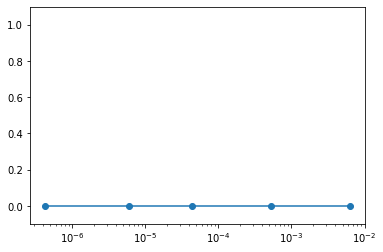

In [22]:
plt.scatter(iae_epsilon, iae_delta)
plt.plot(iae_epsilon, iae_delta)

plt.xscale('log')
plt.ylim(-0.1,1.1)
plt.show()

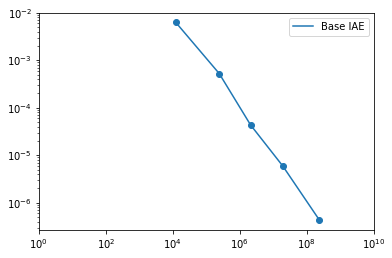

In [13]:
fig = plt.figure()
ax = plt.gca()
ax.scatter(iae_nshots, iae_epsilon)
ax.plot(iae_nshots, iae_epsilon)

ax.legend(['Base IAE'])
ax.set_yscale('log')
ax.set_xscale('log')
plt.xlim(1, 10**10)
plt.show()